# Projet LEYENDA
## Livrable 1 - Classification Binaire

# 1-Importation des bibliothèques
On va regrouper ici l'ensemble des bibliothèques que nous allons utiliser dans ce nootbook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import zipfile

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

D:\Applications\Annaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2-Préparation des images
#### Dézip des fichiers

In [2]:
repertoire = 'D:/Ecole/2023-2024 A5/Data Scientist/Projet/DataL1'
dossier_dataset = 'D:/Ecole/2023-2024 A5/Data Scientist/Projet/Data'
if not os.path.exists(dossier_dataset):
    os.makedirs(dossier_dataset)
    
for fichier in os.listdir(repertoire):
    chemin_fichier = os.path.join(repertoire,fichier)
    if zipfile.is_zipfile(chemin_fichier):
        with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
            zip_ref.extractall(dossier_dataset)
            print(f'Fichier {fichier} décompressé dans le dossier Dataset.')
print('Tous les fichiers ZIP ont été décompressés dans le dossier Dataset')

Fichier Dataset Livrable 1 - Painting.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Photo.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Schematics.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Sketch.zip décompressé dans le dossier Dataset.
Fichier Dataset Livrable 1 - Text.zip décompressé dans le dossier Dataset.
Tous les fichiers ZIP ont été décompressés dans le dossier Dataset


#### Emplacement du dataset
On spécifie ensuite l'emplacement du dataset et on met en place la variable data_dir.

In [8]:
datapath = dossier_dataset
data_dir = pathlib.Path(datapath)

### Création des Set
Pour commencer, on spécifie quelques paramètres pour l'apprentissage :
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>
On crée maintenant nos deux sets, un d'entraînement (80% des data) et un de test (20% des data).

In [21]:
image_h = 80
image_w = 80
batch_s = 32

In [22]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

Found 41399 files belonging to 5 classes.
Using 33120 files for training.
Found 41399 files belonging to 5 classes.
Using 8279 files for validation.


On en profite pour vérifier que les labels ont bien été trouvés :

In [23]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


# 3 - Coup d'œil sur nos données
On peut affichage une des images du set d'entraînements, aux dimensions spécifiées dans les paramètres :

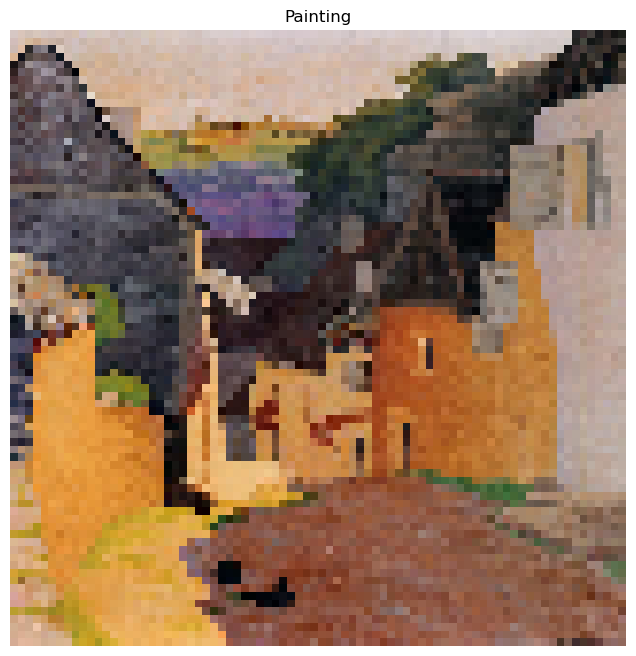

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = Sequential()

In [ ]:
model.add(layers.experimental.preprocessing.Rescaling(1./255))

In [ ]:
# Couche de convolution
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
# Couche de pooling
model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
# Bloc convolutif ou la taille du filtre est de (32, 3)
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

# Bloc convolutif ou la taille du filtre est de (64, 3)
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

# Applatissement de la couche
model.add(layers.Flatten())

# Couche entièrement connectée (couche dense)
model.add(layers.Dense(128, activation='relu'))

# Couche entièrement connectée retournant le résultat de la classification
model.add(layers.Dense(num_classes))

model.build((None, image_h, image_w, 3))
model.summary()

In [ ]:
model.compile(optimizer =  'adam',
              loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 3)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

In [ ]:
# Le modèle
epochs = 8
complete_model =  Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
complete_model.build((None, image_h, image_w, 3))
# Compilation du modèle
complete_model.compile(optimizer =  'adam',
                       loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()
# Enrainement du modèle
history =  complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()